In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  mean_squared_error
from sklearn.preprocessing import StandardScaler
#from google.colab import drive
%matplotlib inline

# 1. Монтируем Google Диск
#drive.mount('/content/drive')

In [32]:
def preprocess_data(data, etalon, limit = 100): #limits в град/ч

    omega = data[:,[1, 2, 3]]/np.pi*180*200*3600 #перевод в град/ч

    begin = 0
    end = 0
    omega_data_cols = [0,1,2]
    transition = np.array([], dtype=int)

    for i in omega_data_cols:
        domega = omega[1:omega.shape[0], i] - omega[0:omega.shape[0]-1, i]
        j=0
        while (j < domega.size):
            if abs(domega[j]) > limit:
                begin = j
                while abs(domega[j]) > limit:
                    j += 1
                end = j
                transition = np.concatenate((transition, np.arange(begin+1, end+1, dtype=int)))
            else:
                j += 1

    data_corr = np.delete(data, transition, axis=0)
    etalon_corr = np.delete(etalon, transition, axis=0)
    return data_corr, etalon_corr

In [34]:
def get_coefs_Logictic_Regression_w(X, y, i, diff = 0.0025):

  print(i)
  X.insert(7, 14, X.iloc[:, 0] * X.iloc[:, i-1])
  X.insert(8, 15, X.iloc[:, 1] * X.iloc[:, i-1])
  X.insert(9, 16, X.iloc[:, 2] * X.iloc[:, i-1])

  X.insert(10, 17, X.iloc[:, 0] * X.iloc[:, i-1]**2)
  X.insert(11, 18, X.iloc[:, 1] * X.iloc[:, i-1]**2)
  X.insert(12, 19, X.iloc[:, 2] * X.iloc[:, i-1]**2)

  X.insert(13, 20, X.iloc[:, 0] * X.iloc[:, i-1]**3)
  X.insert(14, 21, X.iloc[:, 1] * X.iloc[:, i-1]**3)
  X.insert(15, 22, X.iloc[:, 2] * X.iloc[:, i-1]**3)

  X.insert(16, 23, X.iloc[:, i-1]**2)
  X.insert(17, 24, X.iloc[:, i-1]**3)

  X_y = pd.concat([X, y], axis = 1)

#   mask = np.abs(X_y.iloc[:, -1] - X_y.iloc[:, -1].shift(3))
#   X_y = X_y[mask < diff]

  X = X_y.iloc[:, :-1]
  y = X_y.iloc[:, -1]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  model = LinearRegression(fit_intercept=True)
  model.fit(X_train, y_train)
  coefs = model.coef_
  intercept = model.intercept_

  to_return = [coefs] + [intercept]

  y_pred = model.predict(X_test)
  error = mean_squared_error(y_test, y_pred)

  y_pred_full = model.predict(X)

  plt.figure(figsize=(18, 12))
  plt.scatter(np.linspace(0, y_pred_full.shape[0], y_pred_full.shape[0]), y_pred_full)
  plt.scatter(np.linspace(0, y.shape[0], y.shape[0]), y)
  plt.title(f'new_{i}')
  print('Error for w before:', mean_squared_error(X.iloc[:, i-4], y))
  print('Error for w after:', error)
  return to_return, y_pred_full

In [35]:
def get_coefs_Logictic_Regression_omega(X, y, i, diff = 0.025):

  """Тут вроде как-то вот так по умному пишут описание функции.
     В данной функции на вход мы получаем фичи и таргеты и строим линейную регрессию"""

  #Добавим новые признаки по индексу
  X.insert(7, 14, X.iloc[:, 0] * X.iloc[:, 2+i])
  X.insert(8, 15, X.iloc[:, 1] * X.iloc[:, 2+i])
  X.insert(9, 16, X.iloc[:, 2] * X.iloc[:, 2+i])

  X.insert(10, 17, X.iloc[:, 0] * X.iloc[:, 2+i]**2)
  X.insert(11, 18, X.iloc[:, 1] * X.iloc[:, 2+i]**2)
  X.insert(12, 19, X.iloc[:, 2] * X.iloc[:, 2+i]**2)

  X.insert(13, 20, X.iloc[:, 0] * X.iloc[:, 2+i]**3)
  X.insert(14, 21, X.iloc[:, 1] * X.iloc[:, 2+i]**3)
  X.insert(15, 22, X.iloc[:, 2] * X.iloc[:, 2+i]**3)

  X.insert(16, 23, X.iloc[:, 3]**2)
  X.insert(17, 24, X.iloc[:, 3]**3)

  X.insert(18, 25, X.iloc[:, 4]**2)
  X.insert(19, 26, X.iloc[:, 4]**3)

  X.insert(20, 27, X.iloc[:, 5]**2)
  X.insert(21, 28, X.iloc[:, 5]**3)


  # X.insert(22, 29, X.iloc[:, 2+i] - X.iloc[:, 6])
  # X.drop(13, axis =1, inplace = True)

  #В первую очередь нужно выделить ту часть, которая находится на плато, для этого посмотрим на максимальную разность значений на плато
  X_y = pd.concat([X, y], axis = 1)

  #Вот я пока не знаю как подобрать нормально коэффициент, поэтому пока будет так

#   mask = np.abs(X_y.iloc[:, -1] - X_y.iloc[:, -1].shift(3))
#   X_y_sort = X_y.copy()
#   X_y = X_y[mask <= diff]

  X = X_y.iloc[:, :-1]
  y = X_y.iloc[:, -1]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  model = LinearRegression(fit_intercept=False)
  model.fit(X_train, y_train)
  coefs = model.coef_

  to_return = [coefs]

  y_pred = model.predict(X)
  #error = mean_squared_error(y_test, y_pred)
  #print(mean_squared_error(X.iloc[:, i-1], y))
  #print(error)
  return to_return, y_pred

In [36]:
def full_LogicticRegression(file_path_data, file_path_etalon):
  #Подгружаем данные
  data = np.load(file_path_data)
  etalon = np.load(file_path_etalon)

  data, etalon = preprocess_data(data, etalon)

  #Переводим их в датафрейм
  data = pd.DataFrame(data)
  etalon = pd.DataFrame(etalon)

  np.save(f'results/Time.npy', data.iloc[:, 0])
  #Разделяем по колонкам для работы с омегой и с ускорением
  columns_omega = [1, 2, 3, 10, 11, 12, 13]
  columns_w = [4, 5, 6, 7, 8, 9, 13]
  data_fichi_omega = data[columns_omega]
  data_fichi_w = data[columns_w]

  #Переводим данные: омеги в градусы в секунду, а ускорения в м/с^2
  data_targets_omega = etalon[[1, 2, 3]]/3600
  data_targets_w = etalon[[4, 5, 6]]

  for i in range(3):
    data_fichi_omega.iloc[:, i] = data_fichi_omega.iloc[:, i]/np.pi*180*200
    data_fichi_w.iloc[:, i] = data_fichi_w.iloc[:, i]*200

  #Тут строим график, чтобы убедиться в правильности преобразований
  # plt.figure(figsize = (18, 15))
  # plt.scatter(data.iloc[:, 0], data_fichi_omega.iloc[:, 0], alpha=0.05)

  # mask = get_diff(data_targets_omega, 0.25)
  # print(data_fichi_omega.index)


  # data_fichi_omega = data_fichi_omega.iloc[mask]
  # data_fichi_w = data_fichi_w.iloc[mask]
  # data_targets_omega = data_targets_omega.iloc[mask]
  # data_targets_w = data_targets_w.iloc[mask]

#   plt.figure()
#   plt.scatter(data.iloc[:, 0], data_targets_omega.iloc[:, 2], alpha=0.05)
#   plt.show()

#   plt.figure()
#   plt.scatter(data.iloc[:, 0], data_targets_w.iloc[:, 0], alpha=0.05)
#   plt.show()

#   plt.figure()
#   plt.scatter(np.linspace(0, data_targets_w.iloc[:, 0].shape[0], data_targets_w.iloc[:, 0].shape[0]), data_targets_w.iloc[:, 0])
#   plt.xlim(31475, 31500)
#   plt.ylim(0, 2.5)
#   plt.show()

#   plt.figure()
#   plt.scatter(np.linspace(0, data_targets_omega.iloc[:, 2].shape[0], data_targets_omega.iloc[:, 2].shape[0]), data_targets_omega.iloc[:, 2])
#   plt.xlim(31475, 31500)
#   plt.show()


  #Теперь можно начинать лутать коэффициенты
  coefs = {}
  #Тут коэффициенты для омеги
  for target in data_targets_omega.columns:
    coef, y_pred = get_coefs_Logictic_Regression_omega(data_fichi_omega.copy(), data_targets_omega[target], target)
    coefs[f'omega_{target}'] = coef
    np.save(f'results/array_omega{target}.npy', y_pred)

  #Тут коэффициенты для ускорения
  for target in data_targets_w.columns:
    coef, y_pred = get_coefs_Logictic_Regression_w(data_fichi_w.copy(), data_targets_w[target], target)
    coefs[f'w_{target-3}'] = coef
    np.save(f'results/array_w{target-3}.npy', y_pred)


  return coefs

[ 25358  25359  25360 ... 154737 154738 154740]


C:\Users\User\AppData\Local\Temp\ipykernel_12968\2581164323.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fichi_omega.iloc[:, i] = data_fichi_omega.iloc[:, i]/np.pi*180*200
C:\Users\User\AppData\Local\Temp\ipykernel_12968\2581164323.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fichi_w.iloc[:, i] = data_fichi_w.iloc[:, i]*200
C:\Users\User\AppData\Local\Temp\ipykernel_12968\2581164323.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

4
Error for w before: 0.004505701555646887
Error for w after: 0.0001162312415533216
5
Error for w before: 0.0004577912608346865
Error for w after: 0.0001371822591268599
6
Error for w before: 0.007049012113829307
Error for w after: 9.316973251772397e-05


{'omega_1': [array([-8.32176659e-01, -9.03450337e-02, -5.86473081e-02,  3.31501711e-01,
         -1.12584906e-01, -2.14757673e-01, -1.68084157e-03,  2.26509409e-01,
          1.16400297e-02,  6.38866435e-03, -9.32610916e-03, -4.90739048e-04,
         -2.61809768e-04,  1.27886011e-04,  6.89073410e-06,  3.57515231e-06,
         -1.43987615e-02,  2.08051410e-04,  4.65534954e-03, -6.38123091e-05,
          9.53094083e-03, -1.39696992e-04])],
 'omega_2': [array([ 6.07741867e-01,  1.51611806e+00, -1.24764369e+00, -1.53170160e-01,
          1.19634847e-01,  3.72410499e-03,  2.52639231e-02, -7.51877262e-02,
         -6.60354420e-02,  1.52411568e-01,  3.08935917e-03,  2.81522514e-03,
         -6.19892992e-03, -4.22888940e-05, -3.99850530e-05,  8.39884384e-05,
          6.22573738e-03, -8.86399810e-05, -6.08863556e-03,  9.44085470e-05,
          2.47845010e-04, -1.38901456e-05])],
 'omega_3': [array([-2.17192562e-03,  2.89811022e-01,  1.52703509e+00,  3.82196404e-01,
         -3.12194422e-01, -6

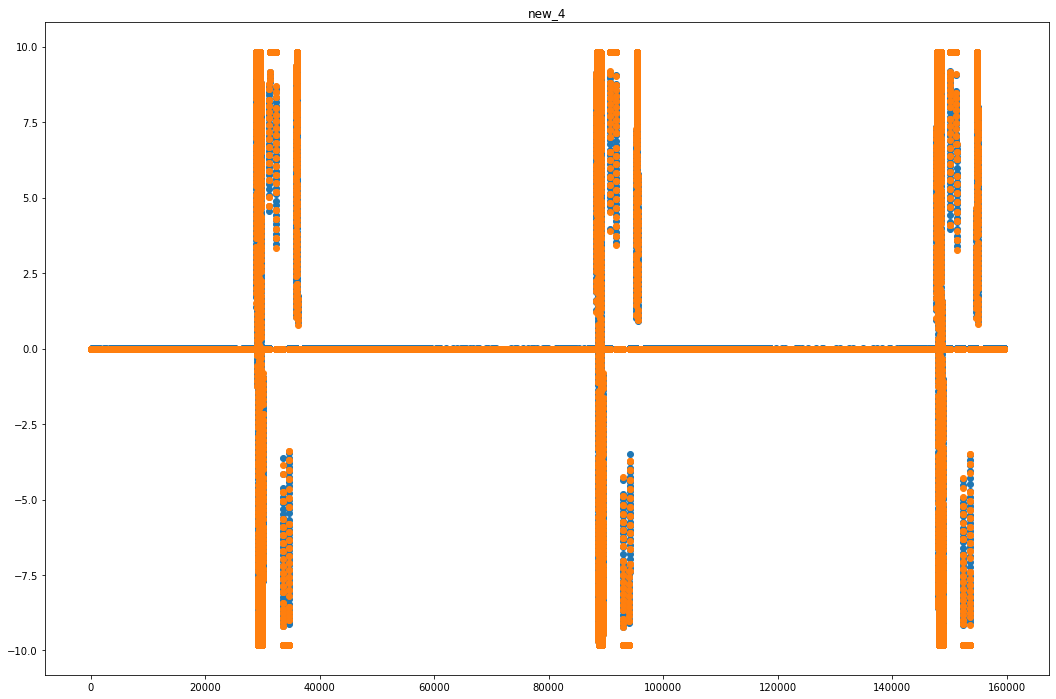

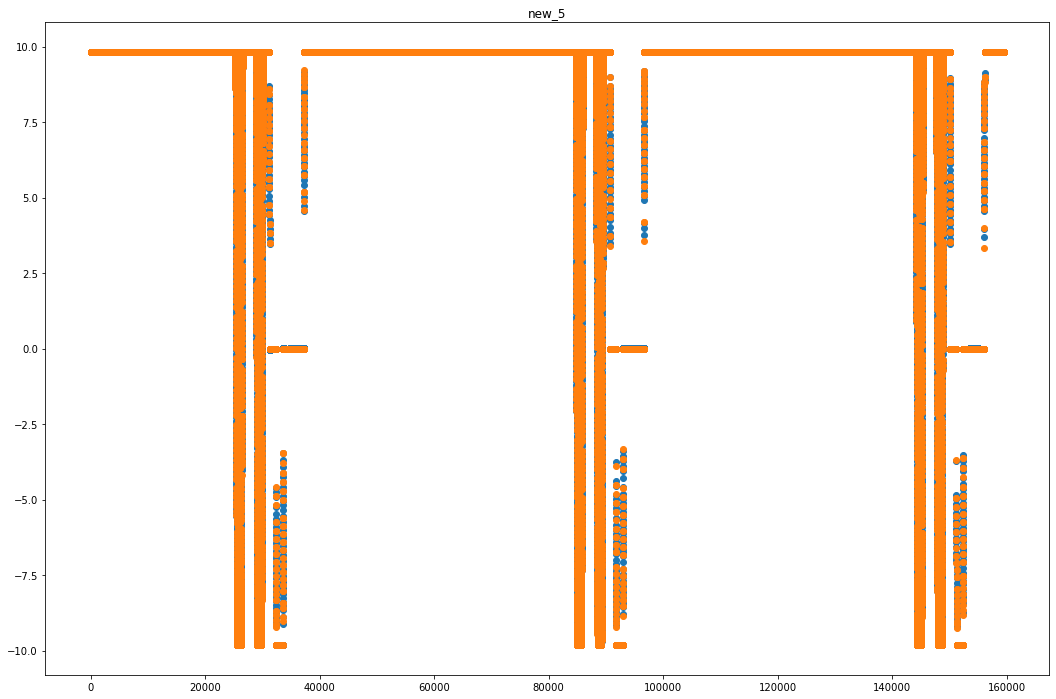

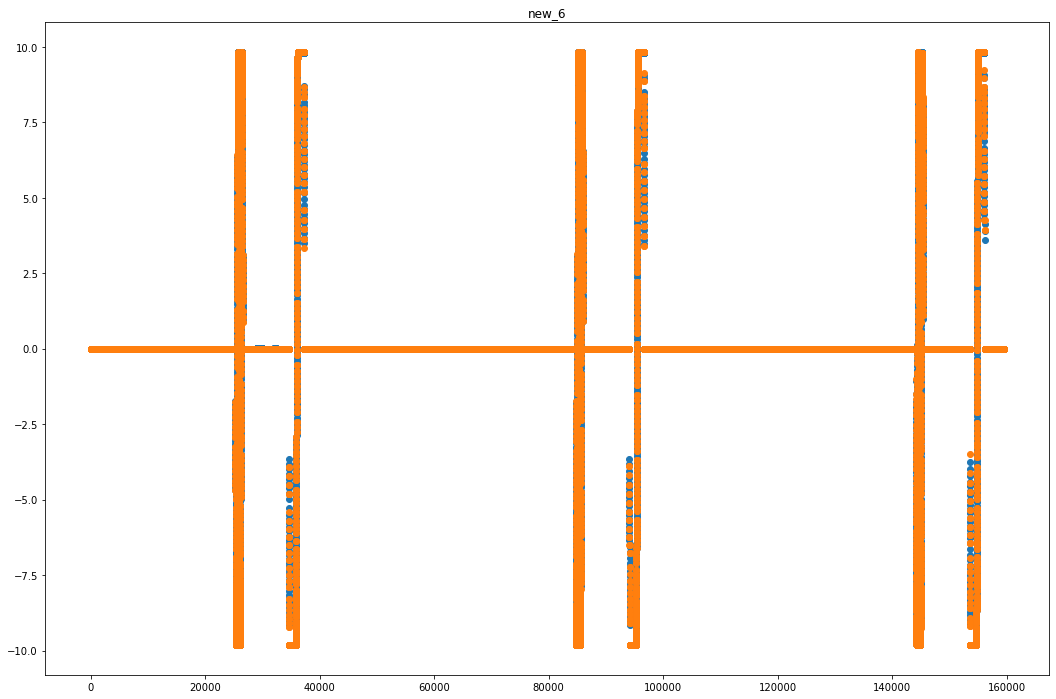

In [37]:
full_LogicticRegression(file_path_data, file_path_etalon)

In [38]:
def print_coefs(filename, coefs_dict):
  coefs_w1 = coefs_dict['w_1']
  KA10 = coefs_w1[0][0] - 1
  KA11 = coefs_w1[0][7]
  KA12 = coefs_w1[0][10]
  KA13 = coefs_w1[0][13]
  GA120 = coefs_w1[0][1]
  GA121 = coefs_w1[0][8]
  GA122 = coefs_w1[0][11]
  GA123 = coefs_w1[0][14]
  GA130 = coefs_w1[0][2]
  GA131 = coefs_w1[0][9]
  GA132 = coefs_w1[0][12]
  GA133 = coefs_w1[0][15]
  a10 = - coefs_w1[1]
  a11 = -coefs_w1[0][3]
  a12 = - coefs_w1[0][16]
  a13 = -coefs_w1[0][17]
  a1MKD = -coefs_w1[0][6]

  coefs_w2 = coefs_dict['w_2']
  KA20 = coefs_w2[0][1] - 1
  KA21 = coefs_w2[0][8]
  KA22 = coefs_w2[0][11]
  KA23 = coefs_w2[0][14]
  GA220 = coefs_w2[0][0]
  GA221 = coefs_w2[0][7]
  GA222 = coefs_w2[0][10]
  GA223 = coefs_w2[0][13]
  GA230 = coefs_w2[0][2]
  GA231 = coefs_w2[0][9]
  GA232 = coefs_w2[0][12]
  GA233 = coefs_w2[0][15]
  a20 = - coefs_w2[1]
  a21 = -coefs_w2[0][4]
  a22 = - coefs_w2[0][16]
  a23 = -coefs_w2[0][17]
  a2MKD = -coefs_w2[0][6]

  coefs_w3 = coefs_dict['w_3']
  KA30 = coefs_w3[0][2] - 1
  KA31 = coefs_w3[0][9]
  KA32 = coefs_w3[0][12]
  KA33 = coefs_w3[0][15]
  GA320 = coefs_w3[0][0]
  GA321 = coefs_w3[0][7]
  GA322 = coefs_w3[0][10]
  GA323 = coefs_w3[0][13]
  GA330 = coefs_w3[0][1]
  GA331 = coefs_w3[0][8]
  GA332 = coefs_w3[0][11]
  GA333 = coefs_w3[0][14]
  a30 = - coefs_w3[1]
  a31 = -coefs_w3[0][5]
  a32 = - coefs_w3[0][16]
  a33 = -coefs_w3[0][17]
  a3MKD = -coefs_w3[0][6]

  coefs_lg1 = coefs_dict['omega_1']
  coefs_lg2 = coefs_dict['omega_2']
  coefs_lg3 = coefs_dict['omega_3']

  with open(filename, 'w') as f:
    for i in range(27):
      f.write('\n')
    f.write('T0=0.000000000000000E+00;град.С \n')
    f.write('M[00]=1.000000000000000E+00;б/р')
    f.write('M[01]=0.000000000000000E+00;б/р')
    f.write('M[02]=0.000000000000000E+00;б/р')
    f.write('M[10]=0.000000000000000E+00;б/р')
    f.write('M[11]=1.000000000000000E+00;б/р')
    f.write('M[12]=0.000000000000000E+00;б/р')
    f.write('M[20]=0.000000000000000E+00;б/р')
    f.write('M[21]=0.000000000000000E+00;б/р')
    f.write('M[22]=1.000000000000000E+00;б/р')

    f.write('[AC1] \n')
    f.write(f"KA10 = {KA10}\n")
    f.write(f"KA11 = {KA11}\n")
    f.write(f"KA12 = {KA12}\n")
    f.write(f"KA13 = {KA13}\n")
    f.write(f"a10 = {a10}\n")
    f.write(f"a11 = {a11}\n")
    f.write(f"a12 = {a12}\n")
    f.write(f"a13 = {a13}\n")
    f.write(f"a1MKD = {a1MKD}\n")

    f.write(f"GA120 = {GA120}\n")
    f.write(f"GA121 = {GA121}\n")
    f.write(f"GA122 = {GA122}\n")
    f.write(f"GA123 = {GA123}\n")
    f.write(f"GA130 = {GA130}\n")
    f.write(f"GA131 = {GA131}\n")
    f.write(f"GA132 = {GA132}\n")
    f.write(f"GA133 = {GA133}\n")


    f.write('[AC2] \n')
    f.write(f"KA20 = {KA20}\n")
    f.write(f"KA21 = {KA21}\n")
    f.write(f"KA22 = {KA22}\n")
    f.write(f"KA23 = {KA23}\n")
    f.write(f"a20 = {a20}\n")
    f.write(f"a21 = {a21}\n")
    f.write(f"a22 = {a22}\n")
    f.write(f"a23 = {a23}\n")
    f.write(f"a2MKD = {a2MKD}\n")

    f.write(f"GA220 = {GA220}\n")
    f.write(f"GA221 = {GA221}\n")
    f.write(f"GA222 = {GA222}\n")
    f.write(f"GA223 = {GA223}\n")
    f.write(f"GA230 = {GA230}\n")
    f.write(f"GA231 = {GA231}\n")
    f.write(f"GA232 = {GA232}\n")
    f.write(f"GA233 = {GA233}\n")


    f.write('[AC3] \n')
    f.write(f"KA30 = {KA30}\n")
    f.write(f"KA31 = {KA31}\n")
    f.write(f"KA32 = {KA32}\n")
    f.write(f"KA33 = {KA33}\n")
    f.write(f"a30 = {a30}\n")
    f.write(f"a31 = {a31}\n")
    f.write(f"a32 = {a32}\n")
    f.write(f"a33 = {a33}\n")
    f.write(f"a3MKD = {a3MKD}\n")

    f.write(f"GA320 = {GA320}\n")
    f.write(f"GA321 = {GA321}\n")
    f.write(f"GA322 = {GA322}\n")
    f.write(f"GA323 = {GA323}\n")
    f.write(f"GA330 = {GA330}\n")
    f.write(f"GA331 = {GA331}\n")
    f.write(f"GA332 = {GA332}\n")
    f.write(f"GA333 = {GA333}\n")

    #Тут нужны гироскопы
    f.write('[LG1]')


    f.write('[LG2]')


    f.write('[LG3]')

In [40]:
file_path_data = "data_average.npy"
file_path_etalon = "etalon.npy"

[ 25358  25359  25360 ... 154737 154738 154740]


C:\Users\User\AppData\Local\Temp\ipykernel_12968\2581164323.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fichi_omega.iloc[:, i] = data_fichi_omega.iloc[:, i]/np.pi*180*200
C:\Users\User\AppData\Local\Temp\ipykernel_12968\2581164323.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fichi_w.iloc[:, i] = data_fichi_w.iloc[:, i]*200
C:\Users\User\AppData\Local\Temp\ipykernel_12968\2581164323.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

4
Error for w before: 0.004505701555646887
Error for w after: 0.0001162312415533216
5
Error for w before: 0.0004577912608346865
Error for w after: 0.0001371822591268599
6
Error for w before: 0.007049012113829307
Error for w after: 9.316973251772397e-05


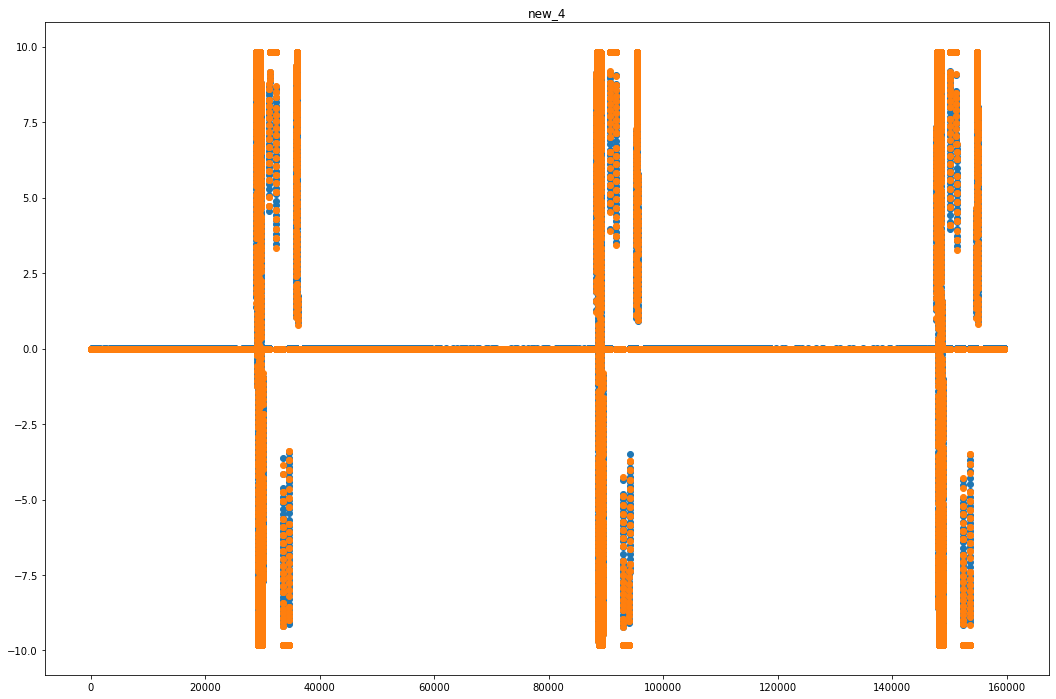

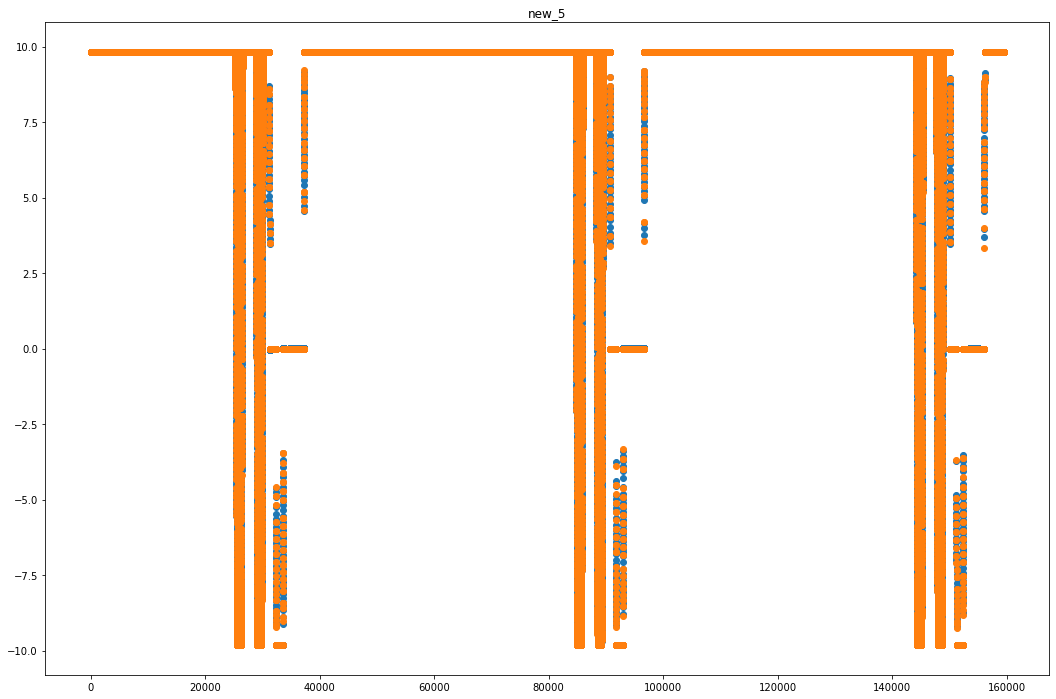

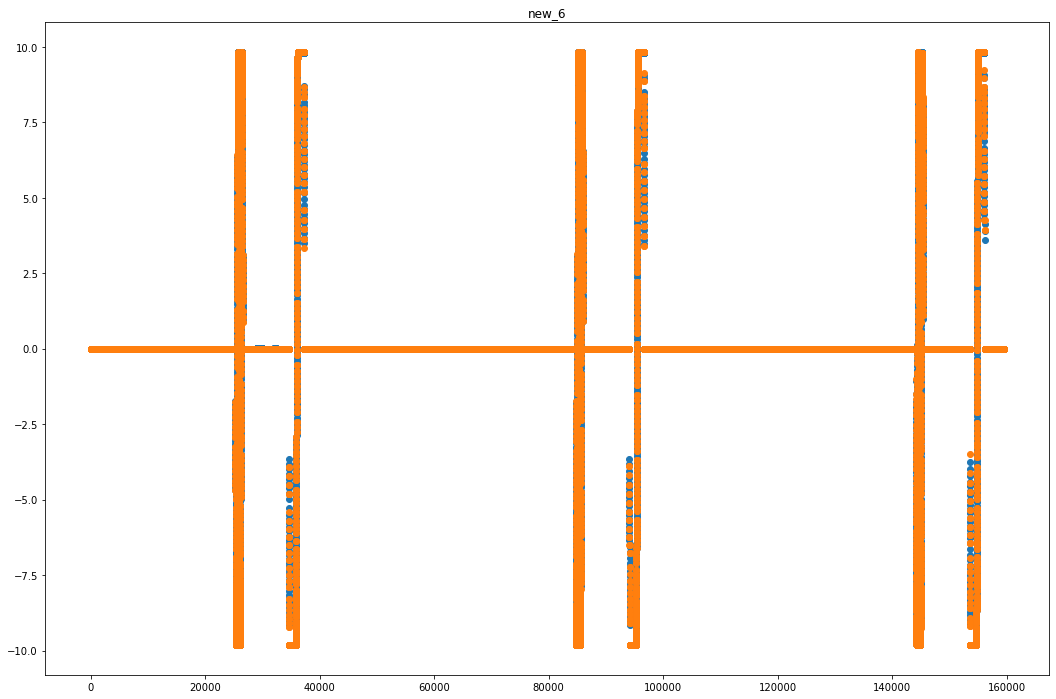

In [39]:
print_coefs('coefs', full_LogicticRegression(file_path_data, file_path_etalon))

In [41]:
array_omega1 = np.load("results/array_omega1.npy")
array_omega2 = np.load("results/array_omega2.npy")
array_omega3 = np.load("results/array_omega3.npy")
array_w1 = np.load("results/array_w1.npy")
array_w2 = np.load("results/array_w2.npy")
array_w3 = np.load("results/array_w3.npy")
Time = np.load("results/Time.npy")


In [47]:
results = np.vstack((Time, array_omega1, array_omega2, array_omega3, array_w1, array_w2, array_w3)).transpose()
results.shape

(159504, 7)

In [49]:
np.savetxt("results/results.txt", results)